## **Modelo predictivo del número de estudiantes en Ecuador**


Este notebook tiene como objetivo construir un modelo predictivo para estimar el número total de estudiantes en Ecuador, utilizando datos históricos. Se realizarán pasos de limpieza, preprocesamiento, análisis exploratorio de datos y finalmente, la construcción y evaluación de un modelo de machine learning para predecir la matrícula estudiantil.

In [34]:
#Importamos todas las librerías necesarias para ejecutar el código
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import ipywidgets as widgets
from IPython.display import display
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
# Cargar archivo (ajusta el nombre si trabajas localmente)
from google.colab import drive, files
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/registro-administrativo-historico_2009-2024-inicio.csv', sep=';', thousands='.', low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#Mostrar las primeras filas del DataFrame para una vista previa de los datos.
df.head()

,Anio_lectivo,Zona,Provincia,Cod_Provincia,Canton,Cod_Canton,Parroquia,Cod_Parroquia,Nombre_Institucion,AMIE,...,Total_Docentes,Estudiantes_Femenino,Estudiantes_Masculino,Total_Estudiantes,Ecuatoriana,Colombiana,Venezolana,Peruana,Otros_Paises_de_America,Otros_Continentes
0,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,EL SAGRARIO,10104.0,UNIDAD EDUCATIVA PARTICULAR ROSA DE JESUS CORDERO,01B00002,...,96.0,1473.0,0.0,1473.0,1455,0,0,0,18,0
1,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,MONAY,10109.0,CEBCI,01B00010,...,25.0,148.0,179.0,327.0,311,3,0,0,9,4
2,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,BAÑOS,10151.0,CENTRO EDUCATIVO ROUSSEAU,01B00019,...,10.0,17.0,23.0,40.0,39,0,0,0,1,0
3,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,BAÑOS,10151.0,COLEGIO INTERCULTURAL BILINGUE DE NARANCAY,01B00020,...,17.0,132.0,132.0,264.0,264,0,0,0,0,0
4,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,CHAUCHA,10153.0,SEIS DE JUNIO,01B00021,...,1.0,18.0,6.0,24.0,24,0,0,0,0,0


In [37]:
#Mostrar información general del DataFrame: número de filas, columnas, tipos de datos y valores no nulos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442716 entries, 0 to 442715
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Anio_lectivo             322602 non-null  object 
 1   Zona                     322602 non-null  object 
 2   Provincia                322602 non-null  object 
 3   Cod_Provincia            322602 non-null  float64
 4   Canton                   322602 non-null  object 
 5   Cod_Canton               322602 non-null  float64
 6   Parroquia                322602 non-null  object 
 7   Cod_Parroquia            322602 non-null  float64
 8   Nombre_Institucion       322602 non-null  object 
 9   AMIE                     322602 non-null  object 
 10  Tipo_Educacion           322602 non-null  object 
 11  Sostenimiento            322602 non-null  object 
 12  Area                     322602 non-null  object 
 13  Regimen_Escolar          322602 non-null  object 
 14  Juri

In [38]:
# Crear una copia de trabajo del DataFrame original para realizar las modificaciones de limpieza y preprocesamiento.
df_clean = df.copy()

In [39]:
# Convertir 'Anio_lectivo' a solo el año de inicio
df_clean = df_clean[df_clean['Anio_lectivo'].notnull()].copy()
df_clean['Anio_Inicio'] = df_clean['Anio_lectivo'].str.extract(r'(\d{4})').astype(int)
# Eliminar la columna original 'Anio_lectivo'
df_clean = df_clean.drop('Anio_lectivo', axis=1)

In [40]:
# Seleccionar columnas tipo float
float_cols = df_clean.select_dtypes(include=['float']).columns

# Convertir columnas flotantes a enteros (si es posible sin perder información)
for col in float_cols:
    # Verificar si la columna contiene solo valores enteros representados como float
    if (df_clean[col] == df_clean[col].astype(int)).all():
        df_clean[col] = df_clean[col].astype(int)
    else:
        print(f"La columna '{col}' contiene valores no enteros y no se puede convertir a int sin pérdida.")

In [41]:
#Estandarizar columnas de texto
text_columns = ['Tipo_Educacion', 'Sostenimiento', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

for col in text_columns:
    df_clean[col] = df_clean[col].str.strip().str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [42]:
# Lista de columnas categóricas a codificar
vars_to_encode = ['Tipo_Educacion', 'Sostenimiento', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

# Codificación one-hot (dummies), eliminando la primera categoría para evitar multicolinealidad
df_clean = pd.get_dummies(df_clean, columns=vars_to_encode, drop_first=True)

In [43]:
# Lista de columnas de interés, incluyendo las originales y las codificadas
# Las columnas codificadas tendrán prefijos basados en los nombres originales
# de las columnas categóricas
columns_of_interest = [
    'Cod_Provincia',
    'Total_Docentes',
    'Total_Estudiantes',
    'Anio_Inicio'
]

# Agregar dinámicamente las columnas codificadas a la lista de interés
# Iteramos sobre las columnas de df_clean y agregamos aquellas que son resultado de get_dummies
for col in df_clean.columns:
    # Comprobamos si la columna comienza con alguno de los prefijos de las variables codificadas
    if any(col.startswith(prefix + '_') for prefix in vars_to_encode):
        columns_of_interest.append(col)

# Crear un nuevo DataFrame con las columnas seleccionadas
df_selected = df_clean[columns_of_interest].copy()

# Mostrar información del nuevo DataFrame para verificar los tipos de datos y columnas
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
Index: 322602 entries, 0 to 322601
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   Cod_Provincia                        322602 non-null  int64
 1   Total_Docentes                       322602 non-null  int64
 2   Total_Estudiantes                    322602 non-null  int64
 3   Anio_Inicio                          322602 non-null  int64
 4   Tipo_Educacion_ordinario             322602 non-null  bool 
 5   Tipo_Educacion_popular permanente    322602 non-null  bool 
 6   Sostenimiento_fiscomisional          322602 non-null  bool 
 7   Sostenimiento_municipal              322602 non-null  bool 
 8   Sostenimiento_particular             322602 non-null  bool 
 9   Area_urbana                          322602 non-null  bool 
 10  Regimen_Escolar_sierra               322602 non-null  bool 
 11  Jurisdiccion_intercultural bilingue  322602 

In [44]:
# Crear copia de df_selected
df_new = df_selected.copy()

In [45]:
#Convertir el año en un índice de tipo datetime
df_selected['Anio'] = pd.to_datetime(df_selected['Anio_Inicio'], format='%Y')
df_selected.set_index('Anio', inplace=True)

# Eliminar la columna Anio_Inicio
df_selected.drop(columns='Anio_Inicio', inplace=True)

In [46]:
# Mostrar las primeras filas del DataFrame con el índice de tiempo.
df_selected.head()

,Cod_Provincia,Total_Docentes,Total_Estudiantes,Tipo_Educacion_ordinario,Tipo_Educacion_popular permanente,Sostenimiento_fiscomisional,Sostenimiento_municipal,Sostenimiento_particular,Area_urbana,Regimen_Escolar_sierra,Jurisdiccion_intercultural bilingue
Anio,,,,,,,,,,,
2009-01-01,1,96,1473,True,False,False,False,True,True,True,False
2009-01-01,1,25,327,True,False,False,False,True,True,True,True
2009-01-01,1,10,40,True,False,False,False,True,False,True,True
2009-01-01,1,17,264,True,False,False,False,False,False,True,True
2009-01-01,1,1,24,True,False,False,False,False,False,False,True


In [47]:
#Mostrar estadísticas descriptivas para las columnas 'Total_Docentes' y 'Total_Estudiantes'.
df_selected[["Total_Docentes", "Total_Estudiantes"]].describe()

,Total_Docentes,Total_Estudiantes
count,322602.000000,322602.000000
mean,10.924895,217.949957
std,18.057507,409.751854
min,0.000000,1.000000
25%,1.000000,21.000000
50%,4.000000,58.000000
75%,13.000000,222.000000
max,374.000000,9463.000000


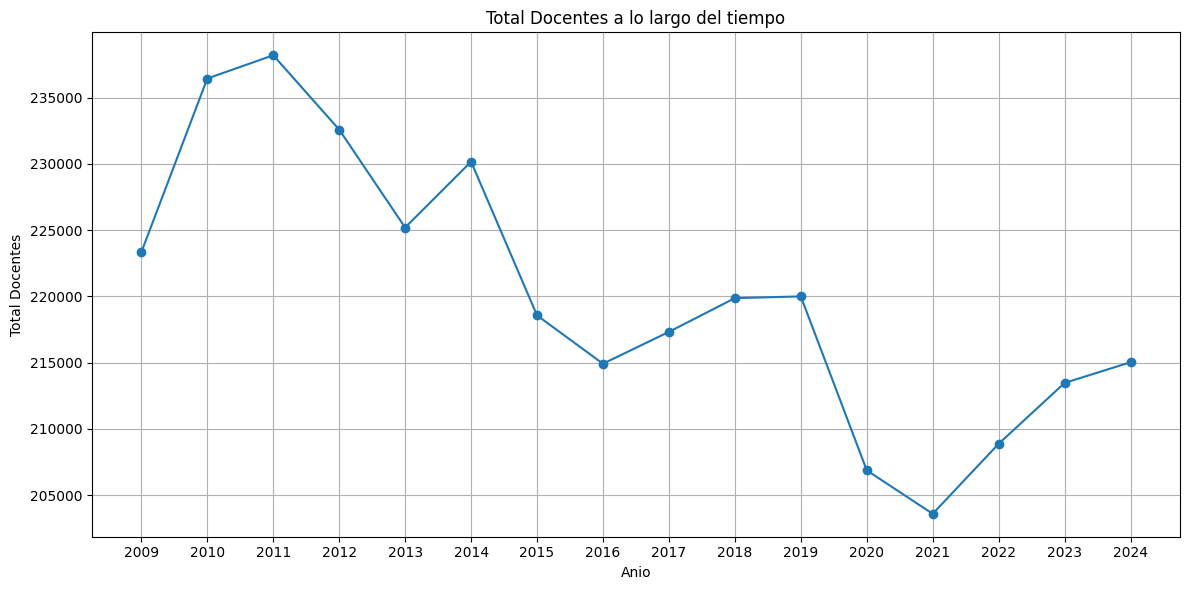

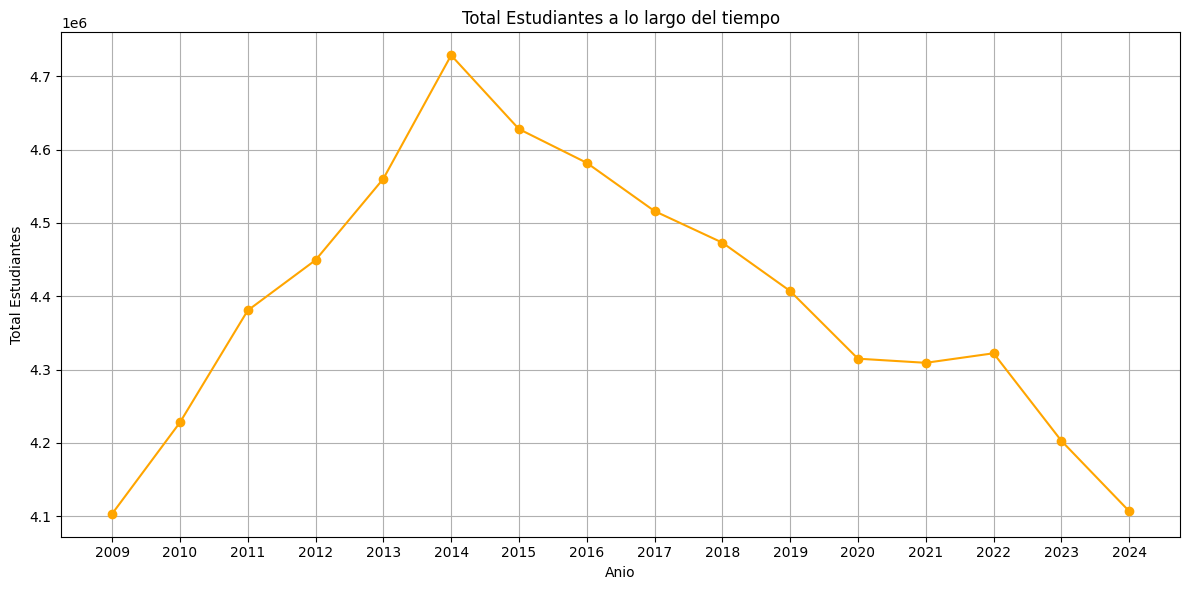

In [48]:
# Agrupar por año y sumar 'Total_Docentes' y 'Total_Estudiantes'
df_yearly_totals = df_selected.groupby('Anio')[['Total_Docentes', 'Total_Estudiantes']].sum()

# Graficar Total_Docentes a lo largo del tiempo (solo año)
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_totals.index.year, df_yearly_totals['Total_Docentes'], marker='o', linestyle='-')
plt.title('Total Docentes a lo largo del tiempo')
plt.xlabel('Anio')
plt.ylabel('Total Docentes')
plt.grid(True)
plt.xticks(df_yearly_totals.index.year) # Asegura que solo se muestren los años en el eje x
plt.tight_layout()
plt.show()

# Graficar Total_Estudiantes a lo largo del tiempo (solo año)
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_totals.index.year, df_yearly_totals['Total_Estudiantes'], marker='o', linestyle='-', color='orange')
plt.title('Total Estudiantes a lo largo del tiempo')
plt.xlabel('Anio')
plt.ylabel('Total Estudiantes')
plt.grid(True)
plt.xticks(df_yearly_totals.index.year) # Asegura que solo se muestren los años en el eje x
plt.tight_layout()
plt.show()

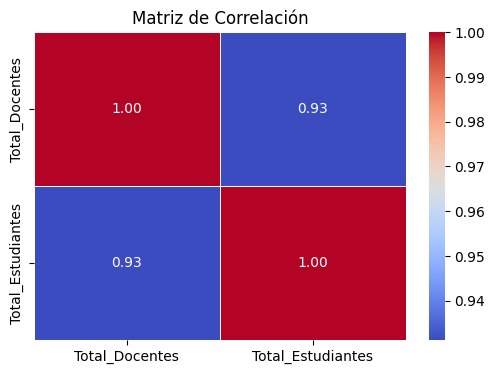

In [49]:
# Calcular la correlación entre 'Total_Docentes' y 'Total_Estudiantes'
corr = df_selected[["Total_Docentes", "Total_Estudiantes"]].corr()

# Dibujar un heatmap de la matriz de correlación.
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

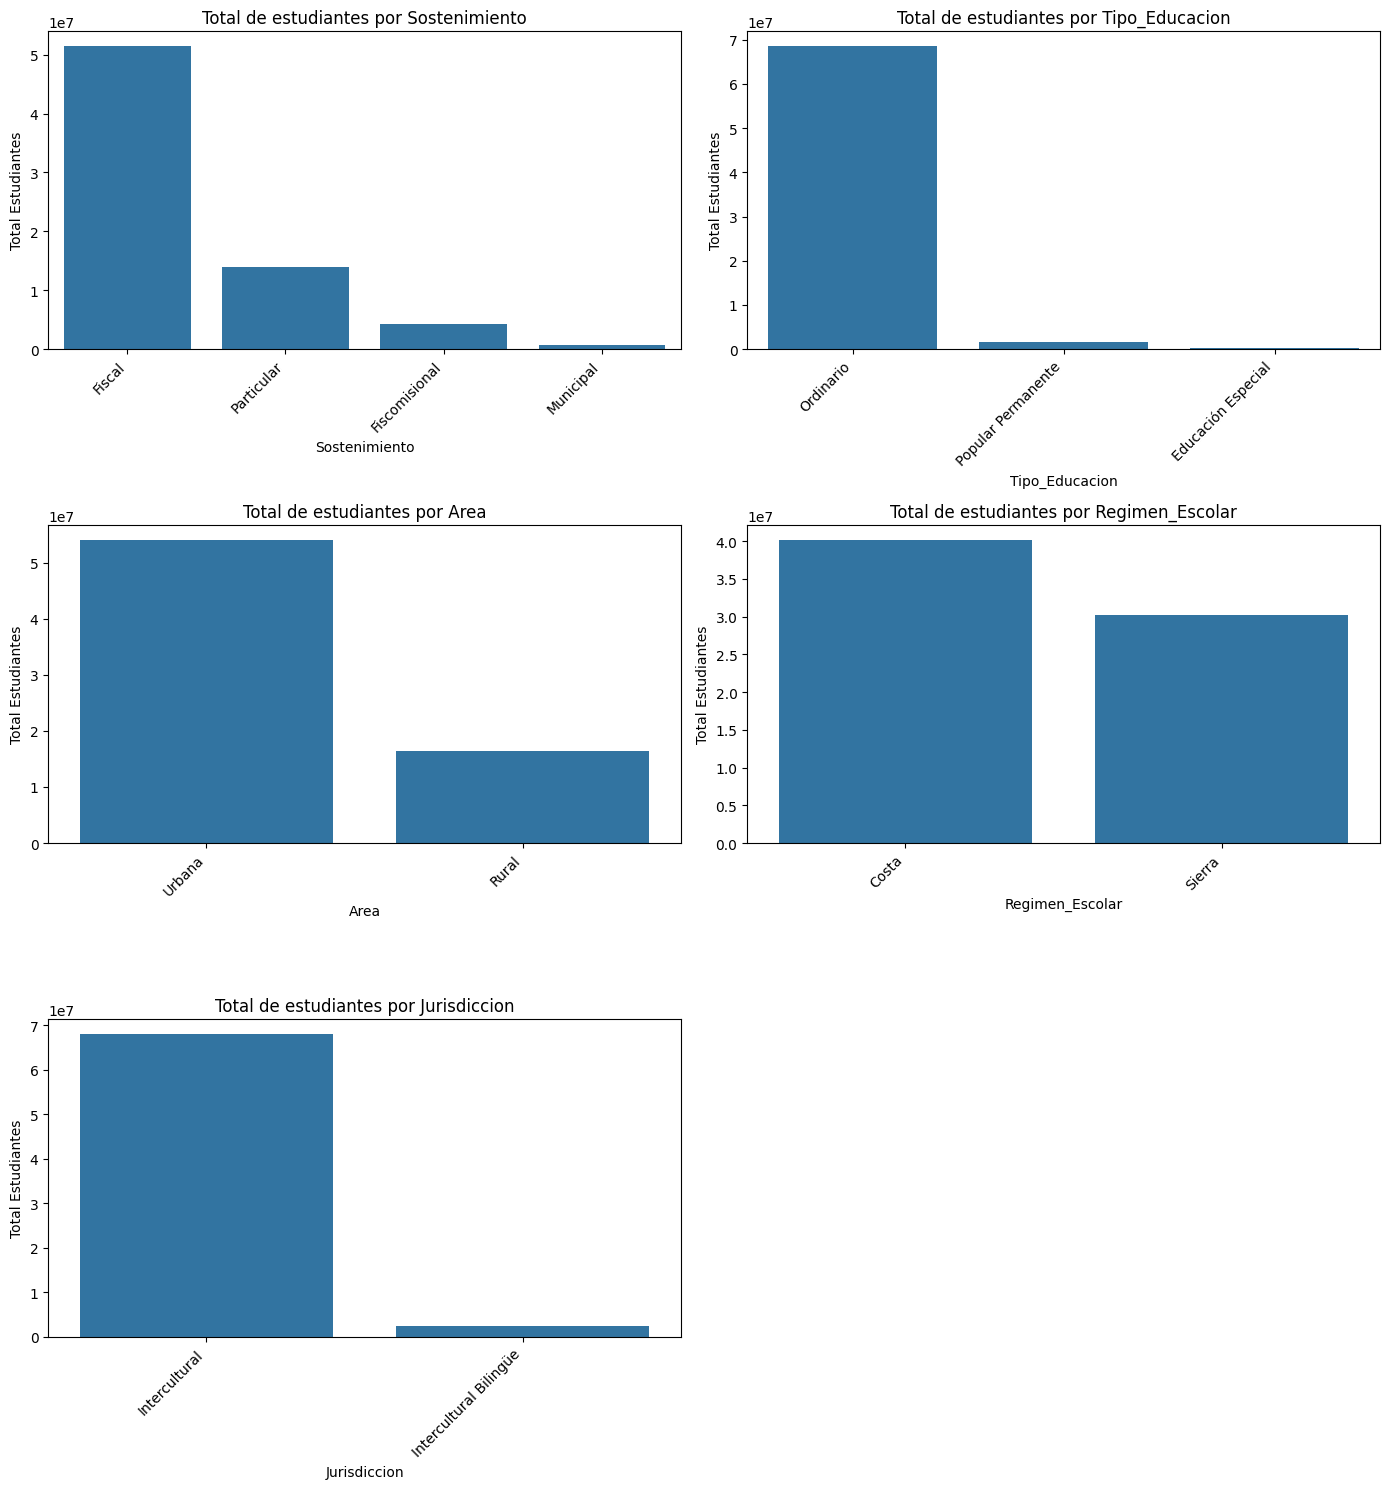

In [50]:
# Variables categóricas para visualización.
categorical_vars = ['Sostenimiento', 'Tipo_Educacion', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

# Configurar subplots para graficar cada variable categórica por separado.
n = len(categorical_vars)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Graficar el total de estudiantes por cada variable categórica.
for i, var in enumerate(categorical_vars):
    df_viz = df.groupby(var)['Total_Estudiantes'].sum().reset_index().sort_values(by='Total_Estudiantes', ascending=False)

    sns.barplot(data=df_viz, x=var, y='Total_Estudiantes', ax=axes[i])
    axes[i].set_title(f'Total de estudiantes por {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Total Estudiantes')

    # Rotar etiquetas de eje x correctamente
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

# Eliminar subplots vacíos si hay más ejes que variables categóricas.
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [51]:
# Lista de columnas que se van a sumar (totales por provincia y año)
cols_sum = ['Total_Estudiantes', 'Total_Docentes']
# Lista de columnas a las que se les calculará el promedio (columnas dummy creadas por get_dummies).
# Se excluyen las columnas de suma y las columnas de identificación/tiempo.
cols_mean = [col for col in df_new.columns if col not in ['Cod_Provincia', 'Anio_Inicio'] + cols_sum]


# Agrupamos por Cod_Provincia y Anio_Inicio y sumamos las columnas especificadas
df_agg = df_new.groupby(['Cod_Provincia', 'Anio_Inicio'])[cols_sum].sum().reset_index()
# Agrupamos por Cod_Provincia y Anio_Inicio y calculamos el promedio de las columnas dummy.
df_dummy_avg = df_new.groupby(['Cod_Provincia', 'Anio_Inicio'])[cols_mean].mean().reset_index()

# Unimos los resultados de las agrupaciones por provincia y año.
df_final = pd.merge(df_agg, df_dummy_avg, on=['Cod_Provincia', 'Anio_Inicio'])

In [52]:
# Crear variables de retraso (lags) para 'Total_Estudiantes'.
# Se crean lags de 1 a 3 años para capturar la dependencia temporal.
for i in range(1, 4):
    df_final[f'Total_Estudiantes_lag{i}'] = df_final.groupby('Cod_Provincia')['Total_Estudiantes'].shift(i)

## Eliminar las filas que contienen valores nulos debido a los lags (las primeras filas de cada provincia).
df_final = df_final.dropna().reset_index(drop=True)

# Convertir las columnas de lag a tipo entero.
for i in range(1, 4):
    df_final[f'Total_Estudiantes_lag{i}'] = df_final[f'Total_Estudiantes_lag{i}'].astype(int)


In [53]:
## Mostrar las primeras filas del DataFrame final con las columnas de lag.
df_final.head()

,Cod_Provincia,Anio_Inicio,Total_Estudiantes,Total_Docentes,Tipo_Educacion_ordinario,Tipo_Educacion_popular permanente,Sostenimiento_fiscomisional,Sostenimiento_municipal,Sostenimiento_particular,Area_urbana,Regimen_Escolar_sierra,Jurisdiccion_intercultural bilingue,Total_Estudiantes_lag1,Total_Estudiantes_lag2,Total_Estudiantes_lag3
0,1,2012,213675,11568,0.923077,0.065295,0.062612,0.010733,0.173524,0.503578,0.759392,0.035778,211092,203494,199677
1,1,2013,219571,11791,0.955366,0.032289,0.029440,0.009497,0.189934,0.503324,0.776828,0.037037,213675,211092,203494
2,1,2014,222499,11703,0.957086,0.030938,0.036926,0.009980,0.181637,0.498004,0.773453,0.035928,219571,213675,211092
3,1,2015,221404,11398,0.955319,0.031915,0.040426,0.011702,0.192553,0.511702,0.768085,0.035106,222499,219571,213675
4,1,2016,218808,11004,0.959954,0.026316,0.044622,0.011442,0.187643,0.525172,0.763158,0.034325,221404,222499,219571


In [54]:
#Division en entrenamiento y pruebas
X = df_final.drop(columns=["Total_Estudiantes"])
y = df_final["Total_Estudiantes"]

#Se dividen los datos en entrenamiento y prueba basados en el año.
#Los datos hasta 2021 se usan para entrenamiento.
X_train = X[df_final["Anio_Inicio"] <= 2021]
y_train = y[df_final["Anio_Inicio"] <= 2021]

#Los datos después de 2021 se usan para pruebas.
X_test = X[df_final["Anio_Inicio"] > 2021]
y_test = y[df_final["Anio_Inicio"] > 2021]


In [55]:
#nicializar y entrenar el modelo XGBoost
model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

#Predicciones con el ocnjunto de prueba
y_pred = model.predict(X_test)

#Evaluación del modelo
#Calcular el Error Cuadrático Medio (MSE).
mse = mean_squared_error(y_test, y_pred)
#Calcular la Raíz del Error Cuadrático Medio (RMSE), que es la raíz cuadrada del MSE.
rmse = np.sqrt(mse)

#Calcular el coeficiente de determinación (R²)
r2 = r2_score(y_test, y_pred)

#Imprimir las métricas de evaluación.
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 9942.10
R²: 0.9982


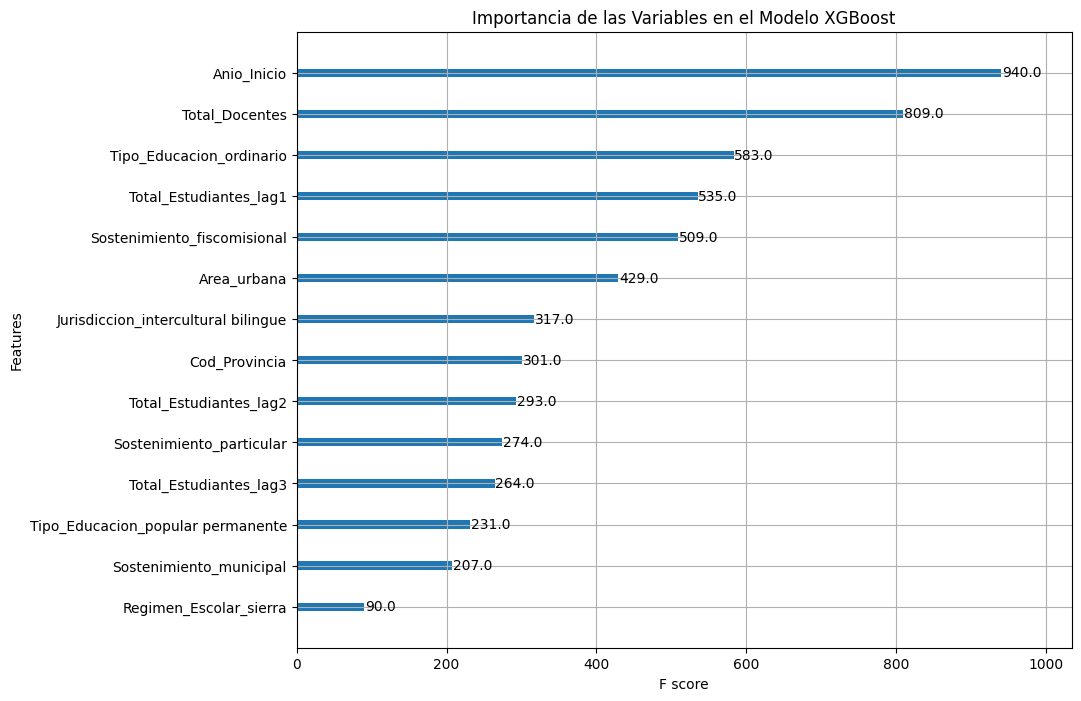


Importancia de las Variables:


,Feature,Importance
1,Anio_Inicio,940.0
2,Total_Docentes,809.0
3,Tipo_Educacion_ordinario,583.0
11,Total_Estudiantes_lag1,535.0
5,Sostenimiento_fiscomisional,509.0
8,Area_urbana,429.0
10,Jurisdiccion_intercultural bilingue,317.0
0,Cod_Provincia,301.0
12,Total_Estudiantes_lag2,293.0
7,Sostenimiento_particular,274.0


In [56]:
#Graficar la importancia de las características
plt.figure(figsize=(10, 8))
plot_importance(model, ax=plt.gca())
plt.title("Importancia de las Variables en el Modelo XGBoost")
plt.show()

#Obtener la importancia de las características como un diccionario
feature_importances = model.get_booster().get_score(importance_type='weight')

#Convertir a DataFrame para un manejo más fácil y ordenar por importancia
importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#Mostrar el DataFrame con la importancia de las variables.
print("\nImportancia de las Variables:")
importance_df

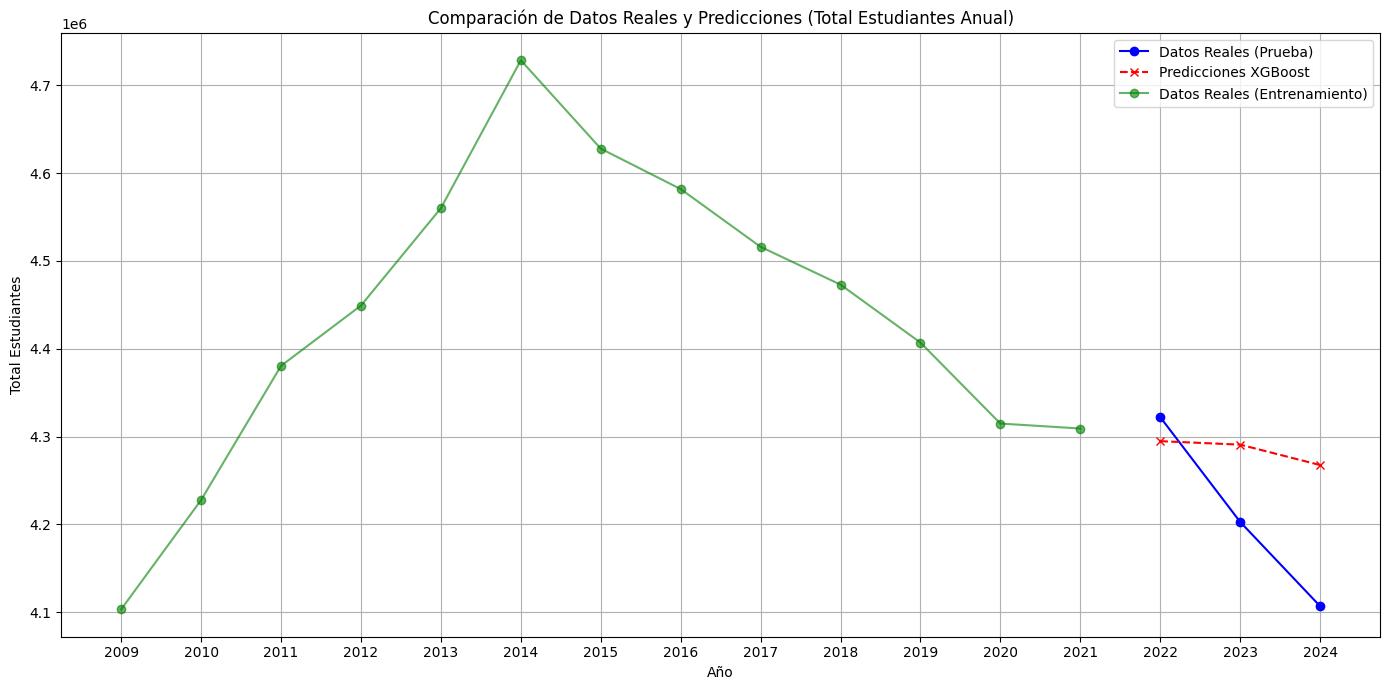

In [57]:
# Realizar la gráfica comparativa
plt.figure(figsize=(14, 7))

# Obtener los años de los datos de prueba
test_years = X_test['Anio_Inicio'].unique()

# Graficar los datos reales (agrupados por año)
# Para obtener los datos reales para el rango de prueba, agrupamos df_yearly_totals
plt.plot(df_yearly_totals.loc[df_yearly_totals.index.year > 2021].index.year,
         df_yearly_totals.loc[df_yearly_totals.index.year > 2021, 'Total_Estudiantes'],
         marker='o', linestyle='-', color='blue', label='Datos Reales (Prueba)')


# Para graficar las predicciones, necesitamos agrupar las predicciones por año
# Creamos un DataFrame temporal para alinear predicciones con años
df_pred = pd.DataFrame({'Anio_Inicio': X_test['Anio_Inicio'], 'Prediccion': y_pred})
df_pred_yearly = df_pred.groupby('Anio_Inicio')['Prediccion'].sum()

# Graficar las predicciones (agrupadas por año)
plt.plot(df_pred_yearly.index, df_pred_yearly.values,
         marker='x', linestyle='--', color='red', label='Predicciones XGBoost')

# Opcional: Graficar los datos reales de entrenamiento para contexto
plt.plot(df_yearly_totals.loc[df_yearly_totals.index.year <= 2021].index.year,
         df_yearly_totals.loc[df_yearly_totals.index.year <= 2021, 'Total_Estudiantes'],
         marker='o', linestyle='-', color='green', label='Datos Reales (Entrenamiento)', alpha=0.6)


plt.title('Comparación de Datos Reales y Predicciones (Total Estudiantes Anual)')
plt.xlabel('Año')
plt.ylabel('Total Estudiantes')
plt.grid(True)
plt.legend()
plt.xticks(df_yearly_totals.index.year) # Asegura que todos los años con datos aparezcan
plt.tight_layout()
plt.show()

In [58]:
# Diccionario para almacenar los resultados RMSE por provincia
rmse_por_provincia = {}

# Obtener la lista única de códigos de provincia en el conjunto de prueba
provincias_test = X_test['Cod_Provincia'].unique()

# Iterar sobre cada provincia
for cod_provincia in provincias_test:
    # Filtrar los datos de entrenamiento y prueba para la provincia actual
    X_train_prov = X_train[X_train['Cod_Provincia'] == cod_provincia]
    y_train_prov = y_train[X_train['Cod_Provincia'] == cod_provincia]

    X_test_prov = X_test[X_test['Cod_Provincia'] == cod_provincia]
    y_test_prov = y_test[X_test['Cod_Provincia'] == cod_provincia]

    # Asegurarse de que haya datos tanto en entrenamiento como en prueba para la provincia
    if not X_train_prov.empty and not X_test_prov.empty:
        # Entrenar un nuevo modelo XGBoost para esta provincia
        # (Se podría considerar reusar el modelo general si el dataset es pequeño por provincia)
        # Para este ejemplo, entrenamos uno nuevo por provincia para ver el rendimiento específico
        model_prov = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
        model_prov.fit(X_train_prov, y_train_prov)

        # Realizar predicciones para la provincia actual
        y_pred_prov = model_prov.predict(X_test_prov)

        # Calcular el RMSE para la provincia actual
        mse_prov = mean_squared_error(y_test_prov, y_pred_prov)
        rmse_prov = np.sqrt(mse_prov)

        # Almacenar el RMSE en el diccionario
        rmse_por_provincia[cod_provincia] = rmse_prov
    else:
        print(f"No hay suficientes datos para la provincia {cod_prov_provincia}. Saltando...")


# Ordenar las provincias por RMSE (de menor a mayor)
rmse_ordenado = sorted(rmse_por_provincia.items(), key=lambda item: item[1])

# Encontrar la provincia con el mejor RMSE (el más bajo)
mejor_provincia = rmse_ordenado[0] if rmse_ordenado else (None, None)

print("\nRMSE por Provincia (Ordenado):")
for provincia, rmse_val in rmse_ordenado:
    print(f"Provincia Codigo {provincia}: RMSE = {rmse_val:.2f}")

if mejor_provincia[0] is not None:
    print(f"\nLa provincia con el mejor RMSE es la {mejor_provincia[0]} con un RMSE de {mejor_provincia[1]:.2f}")
else:
    print("\nNo se pudieron calcular RMSEs por provincia.")




RMSE por Provincia (Ordenado):
Provincia Codigo 19: RMSE = 368.17
Provincia Codigo 16: RMSE = 438.05
Provincia Codigo 20: RMSE = 442.30
Provincia Codigo 14: RMSE = 969.27
Provincia Codigo 15: RMSE = 1903.35
Provincia Codigo 22: RMSE = 2251.30
Provincia Codigo 24: RMSE = 2629.64
Provincia Codigo 4: RMSE = 2629.67
Provincia Codigo 21: RMSE = 2733.42
Provincia Codigo 23: RMSE = 2849.60
Provincia Codigo 2: RMSE = 3570.04
Provincia Codigo 3: RMSE = 3961.96
Provincia Codigo 10: RMSE = 4331.53
Provincia Codigo 11: RMSE = 4760.08
Provincia Codigo 18: RMSE = 4951.94
Provincia Codigo 13: RMSE = 5134.70
Provincia Codigo 5: RMSE = 5758.12
Provincia Codigo 7: RMSE = 5799.03
Provincia Codigo 12: RMSE = 6027.89
Provincia Codigo 90: RMSE = 7152.00
Provincia Codigo 1: RMSE = 7830.19
Provincia Codigo 6: RMSE = 8179.58
Provincia Codigo 8: RMSE = 10721.79
Provincia Codigo 9: RMSE = 25581.60
Provincia Codigo 17: RMSE = 37149.72

La provincia con el mejor RMSE es la 19 con un RMSE de 368.17


In [59]:
def predecir_futuro(df_final, model, features, anio_inicio=2025, anios_futuro=4):
    """
    Predice el total de estudiantes por provincia para los próximos años.

    Parámetros:
    - df_final: DataFrame con columnas originales + lags.
    - model: modelo XGBoost entrenado.
    - features: lista de columnas utilizadas para entrenamiento.
    - anio_inicio: primer año a predecir.
    - anios_futuro: cuántos años futuros predecir.

    Retorna:
    - DataFrame con predicciones por provincia y año.
    """
    registros = []

    #Último año por provincia: Obtiene la última fila de datos disponible para cada provincia, ordenada por año.
    df_prov = df_final.sort_values("Anio_Inicio").groupby("Cod_Provincia").tail(1).copy()

    #Itera para cada año futuro a predecir
    for i in range(anios_futuro):
        anio = anio_inicio + i
        df_fut = df_prov.copy()
        df_fut["Anio_Inicio"] = anio

        # Actualizar los lags (lag5 ← lag4 ← ... ← lag1 ← predicción anterior)
        for lag in range(3, 1, -1):
            df_fut[f'Total_Estudiantes_lag{lag}'] = df_fut[f'Total_Estudiantes_lag{lag - 1}']
        df_fut['Total_Estudiantes_lag1'] = df_fut['Total_Estudiantes']  # último valor real o predicho

        # Eliminar columna objetivo si existe
        if 'Total_Estudiantes' in df_fut.columns:
            df_fut.drop(columns=['Total_Estudiantes'], inplace=True)

        # Predecir usando las variables que el modelo espera
        df_fut['Total_Estudiantes'] = model.predict(df_fut[features]).astype(int)

        # Guardar resultado
        registros.append(df_fut[['Cod_Provincia', 'Anio_Inicio', 'Total_Estudiantes']])

        # Preparar para siguiente iteración
        df_prov = df_fut.copy()

    # Concatenar resultados
    return pd.concat(registros, ignore_index=True)


In [60]:
#Lista de características que fueron utilizadas para entrenar el modelo XGBoost.
#Esta lista es necesaria para que la función de predicción utilice las mismas columnas.
features = [
    'Cod_Provincia', 'Anio_Inicio', 'Total_Docentes',
    'Tipo_Educacion_ordinario', 'Tipo_Educacion_popular permanente',
    'Sostenimiento_fiscomisional', 'Sostenimiento_municipal', 'Sostenimiento_particular',
    'Area_urbana', 'Regimen_Escolar_sierra', 'Jurisdiccion_intercultural bilingue',
    'Total_Estudiantes_lag1', 'Total_Estudiantes_lag2',
    'Total_Estudiantes_lag3'
]

# Imprimir la lista de características para verificación.
print(features)


['Cod_Provincia', 'Anio_Inicio', 'Total_Docentes', 'Tipo_Educacion_ordinario', 'Tipo_Educacion_popular permanente', 'Sostenimiento_fiscomisional', 'Sostenimiento_municipal', 'Sostenimiento_particular', 'Area_urbana', 'Regimen_Escolar_sierra', 'Jurisdiccion_intercultural bilingue', 'Total_Estudiantes_lag1', 'Total_Estudiantes_lag2', 'Total_Estudiantes_lag3']


In [61]:
# Realizar las predicciones para los próximos 4 años, comenzando en 2025.
# Se llama a la función predecir_futuro con el DataFrame final, el modelo entrenado y la lista de características.
df_predicciones = predecir_futuro(df_final, model, features, anio_inicio=2025, anios_futuro=4)
# Exportar las predicciones a un archivo CSV llamado "predicciones_matriculados.csv".
df_predicciones.to_csv("predicciones_matriculados.csv", index=False)
#Exportar documento CSV
files.download("predicciones_matriculados.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
# Widget de entrada de texto para el código de provincia
provincia_input = widgets.Text(
    value='',
    placeholder='Ingrese Código de Provincia',
    description='Provincia:',
    disabled=False
)

# Widget de entrada de texto para el año
anio_input = widgets.Text(
    value='',
    placeholder='Ingrese Año (2025 en adelante)',
    description='Año:',
    disabled=False
)

# Botón para ver la predicción
ver_prediccion_button = widgets.Button(
    description='Ver Predicción'
)

# Output para mostrar el resultado
output = widgets.Output()

# Función para manejar el evento click del botón
def on_button_clicked(b):
    with output:
        output.clear_output()  # Limpiar salida anterior
        try:
            # Obtener los valores ingresados por el usuario
            cod_provincia_str = provincia_input.value
            anio_str = anio_input.value

            # Validar que los campos no estén vacíos
            if not cod_provincia_str or not anio_str:
                print("Por favor, ingrese tanto el código de provincia como el año.")
                return

            cod_provincia = int(cod_provincia_str)
            anio = int(anio_str)

            # Filtrar las predicciones para la provincia y año especificados
            prediccion_filtrada = df_predicciones[
                (df_predicciones['Cod_Provincia'] == cod_provincia) &
                (df_predicciones['Anio_Inicio'] == anio)
            ]

            # Mostrar el resultado
            if not prediccion_filtrada.empty:
                total_estudiantes_pred = prediccion_filtrada['Total_Estudiantes'].iloc[0]
                print(f"Predicción para Provincia {cod_provincia} en {anio}: {total_estudiantes_pred} estudiantes")
            else:
                print(f"No se encontró predicción para Provincia {cod_provincia} en el año {anio}. Asegúrese de ingresar un año desde 2025 en adelante.")

        except ValueError:
            print("Por favor, ingrese valores numéricos válidos para el código de provincia y el año.")
        except Exception as e:
            print(f"Ocurrió un error: {e}")


# Asociar la función al evento click del botón
ver_prediccion_button.on_click(on_button_clicked)

# Mostrar los widgets
display(provincia_input, anio_input, ver_prediccion_button, output)
# Agregar un título explicativo
print("Ingrese el código de provincia y el año para ver la predicción de estudiantes.")

Text(value='', description='Provincia:', placeholder='Ingrese Código de Provincia')

Text(value='', description='Año:', placeholder='Ingrese Año (2025 en adelante)')

Button(description='Ver Predicción', style=ButtonStyle())

Output()

Ingrese el código de provincia y el año para ver la predicción de estudiantes.
